<a href="https://colab.research.google.com/github/mocccca/cmor438/blob/main/Supervised%20Learning/Logistic%20Regression/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Logistic regression class***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_theme()

In [ ]:
class LogisticRegression:
    def __init__(self):
        self.weights = None
        self.loss_history = []
        self.feature_names = None
        self.target_name = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, learning_rate=0.01, max_iter=1000, tol=1e-4):
        """Enhanced with convergence monitoring and standardization"""
        self.feature_names = X.columns.tolist()
        self.target_name = y.name

        X = X.copy()
        # Standardize continuous predictors (age, ocb, absorption)
        self.means = X.mean()
        self.stds = X.std()
        X = (X - self.means) / self.stds

        X = np.column_stack([np.ones(X.shape[0]), X])
        y = y.values

        self.weights = np.zeros(X.shape[1])

        for i in range(max_iter):
            z = np.dot(X, self.weights)
            y_pred = self.sigmoid(z)

            # Gradient calculation
            gradient = np.dot(X.T, (y_pred - y)) / y.size
            self.weights -= learning_rate * gradient

            # Log loss calculation
            loss = -(y * np.log(y_pred) + (1-y)*np.log(1-y_pred)).mean()
            self.loss_history.append(loss)

            if len(self.loss_history) > 1 and abs(self.loss_history[-1] - self.loss_history[-2]) < tol:
                break

    def predict_proba(self, X):
        """Return probabilities"""
        X = (X - self.means) / self.stds
        X = np.column_stack([np.ones(X.shape[0]), X])
        return self.sigmoid(np.dot(X, self.weights))

    def predict(self, X, threshold=0.5):
        """Return binary predictions"""
        return (self.predict_proba(X) >= threshold).astype(int)

    def evaluate(self, X, y):
        """Comprehensive model evaluation"""
        y_pred = self.predict(X)
        y_prob = self.predict_proba(X)

        # Confusion matrix
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # ROC Curve
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': roc_auc,
            'confusion_matrix': cm
        }

    def plot_roc(self, X, y):
        """Plot ROC curve"""
        y_prob = self.predict_proba(X)
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def summary(self):
        """Statistical summary of the model"""
        odds_ratios = np.exp(self.weights)
        return pd.DataFrame({
            'Feature': ['Intercept'] + self.feature_names,
            'Coefficient': self.weights,
            'Odds_Ratio': odds_ratios,
            'Pct_Change': (odds_ratios - 1) * 100
        })

In [ ]:
url = "https://raw.githubusercontent.com/mocccca/cmor438/main/Leisure_Intereset_Dataset.csv"
li = pd.read_csv(url)
li2 = li[['org_status_3', 'age', 'ocb_composite','education_level']].copy()
li2

,org_status_3,age,ocb_composite,education_level
0,1,54,39,5
1,1,50,38,6
2,0,60,17,5
3,0,36,34,5
4,1,23,28,5
...,...,...,...,...
116,1,50,33,5
117,0,50,19,3
118,1,36,32,5
119,0,49,21,5


In [ ]:
# For RIASEC domain - realistic

li2['ip_realistic'] = li['ipa_realistic'].combine_first(li['ipb_realistic'])

# Verify combination worked
print(li[['ipa_realistic', 'ipb_realistic']], li2['ip_realistic'].head(10))

# Check for any remaining missing values
print("Missing after combination:", li2['ip_realistic'].isna().sum())

     ipa_realistic  ipb_realistic
0             25.0            NaN
1             26.0            NaN
2              NaN           24.0
3              NaN           21.0
4             24.0            NaN
..             ...            ...
116            NaN           15.0
117           27.0            NaN
118            NaN           29.0
119            NaN           12.0
120           28.0            NaN

[121 rows x 2 columns] 0    25.0
1    26.0
2    24.0
3    21.0
4    24.0
5    18.0
6    28.0
7    32.0
8     8.0
9    32.0
Name: ip_realistic, dtype: float64
Missing after combination: 0


In [ ]:
# Define ordered categories
education_levels = [
    "Less than high school",
    "High school degree",
    "Some college",
    "Associate degree",
    "Bachelor’s degree",
    "Master’s degree",
    "Professional degree",
    "Doctorate"
]

# Convert to ordered categorical (preserving original 1-8 codes)
li2['education_level'] = pd.Categorical(
    li2['education_level'],
    categories=[1, 2, 3, 4, 5, 6, 7, 8],  # Your original codes
    ordered=True
)

# Verify
print(li2['education_level'].value_counts().sort_index())
print(li2['education_level'].dtype)
li2['education_ordinal'] = li2['education_level'].cat.codes  # Automatically maps to 0-7

education_level
1    21
2    11
3    50
4    27
5     3
6     0
7     0
8     0
Name: count, dtype: int64
category


In [ ]:
# Define variables
X = li2[['age', 'ocb_composite', 'ip_realistic','education_ordinal']]
y = li2['org_status_3']  # supervise people

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X = li2[['age', 'ocb_composite', 'education_ordinal', 'ip_realistic']]
y = li2['org_status_3']

# Split and fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression()
model.fit(X_train, y_train)

# Check coefficients
# Accessing the weights attribute instead of coef_
print(pd.DataFrame({
    'Feature': ['age', 'ocb_composite', 'education_ordinal','ip_realistic'],
    'Coefficient': model.weights[1:]  # Exclude the intercept
}))

             Feature  Coefficient
0                age     0.070168
1      ocb_composite     0.195917
2  education_ordinal     0.061619
3       ip_realistic     0.169710


                              Value
accuracy                       0.72
precision                  0.777778
recall                     0.583333
f1                         0.666667
auc                        0.833333
confusion_matrix  [[11, 2], [5, 7]]

Model Coefficients:
             Feature  Coefficient  Odds_Ratio  Pct_Change
0          Intercept    -0.100135    0.904715   -9.528496
1                age     0.070168    1.072688    7.268823
2      ocb_composite     0.195917    1.216426   21.642551
3  education_ordinal     0.061619    1.063557    6.355722
4       ip_realistic     0.169710    1.184961   18.496060


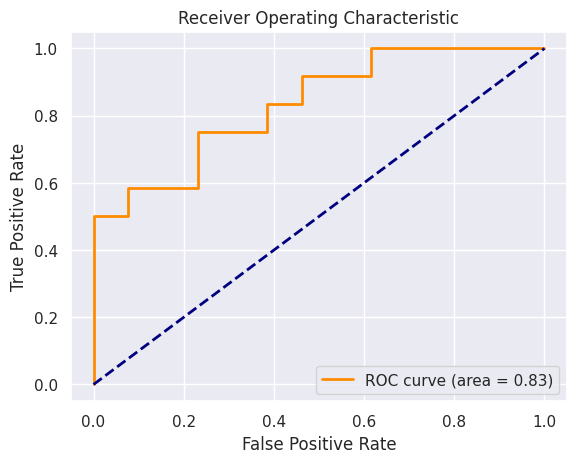

In [ ]:
# Initialize and train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
results = model.evaluate(X_test, y_test)
print(pd.DataFrame.from_dict(results, orient='index', columns=['Value']))

# Show coefficients and odds ratios
print("\nModel Coefficients:")
print(model.summary())

# Plot ROC curve
model.plot_roc(X_test, y_test)

Text(0.5, 1.0, 'Residual Plot')

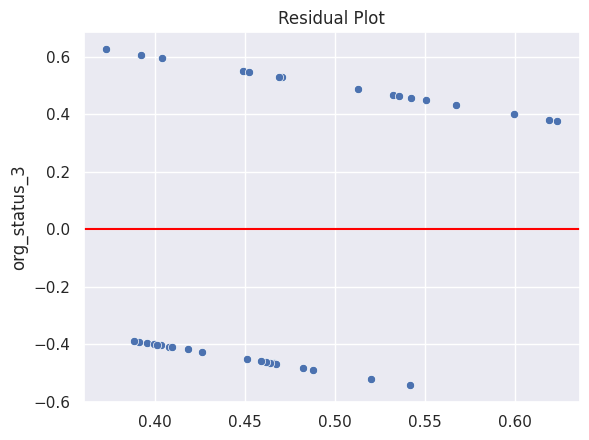

In [ ]:
residuals = y_test - model.predict_proba(X_test)
sns.scatterplot(x=model.predict_proba(X_test), y=residuals)
plt.axhline(0, color='red')
plt.title("Residual Plot")